In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [2]:
# Importar funciones importantes de grafos de mi autoria
from funciones_grafos import *

## Clasificacion Binaria (conectividad grafo 20x20) con Pytorch

#### Hyper parameters

In [3]:
# que porcentaje de los 1000000 datos se van a usar
porcentaje_datos = 0.2
# que porcentaje de los datos a utilizar es de entrenamiento
tr_r = 0.5
# tamaño de un batch
batch_s = 1280
# learning rate
lr = 0.005
# numero de epocas a entrenar
num_epochs = 30

### Funcion para crear un dataset

In [4]:
class create_pytorch_dataset(Dataset):
    
    def __init__(self, name_datos_graphs, name_datos_labels, porcentaje = 1):
        super().__init__()
        
        # obtener la ruta completa de los archivos
        file_path_datos_graphs = '.\\datos\\' + name_datos_graphs + '.npy'
        file_path_datos_labels = '.\\datos\\' + name_datos_labels + '.npy'
        # cargar los datos
        self.datos_grafos = np.load(file_path_datos_graphs)
        self.datos_labels = np.load(file_path_datos_labels)
        
        # solo tomar un porcentaje de los datos, delimitar la longuitud del dataset
        self.cantidad = len(self.datos_labels)
        self.datos_grafos = self.datos_grafos[:int(porcentaje * self.cantidad)]
        self.datos_labels = self.datos_labels[:int(porcentaje * self.cantidad)]
        self.cantidad = len(self.datos_labels)
        
    # longuitud del dataset    
    def __len__(self):
        return self.cantidad
    
    # obtener un elemento, asociado con el indice idx
    # esto consiste en un grafo (representacion vectorial) y su etiqueta
    def __getitem__(self, idx):
        grafo = self.datos_grafos[idx]
        etiqueta = self.datos_labels[idx]
        
        # hacerlos tensor con el tipo de dato correcto
        grafo = torch.from_numpy(grafo).float()
        #etiqueta = torch.tensor(np.array([etiqueta])).long()
        etiqueta  = torch.tensor(etiqueta).long()                           
        return grafo, etiqueta

### Crear el dataset

Haciendo uso de los datos creados en "Crear_Datos.IPYNB"

In [5]:
file_X = 'datos_edros_N1000000_n20_multiple_p'
file_y =  'datos_edros_N1000000_n20_multiple_p_etiqueta_conectividad'
dataset = create_pytorch_dataset(file_X, file_y, porcentaje_datos)

### Ver un poco el dataset

In [6]:
numero_grafos = len(dataset)
print(f'Number of graphs: {numero_grafos}')
num_c = len(np.unique(dataset.datos_labels))
print(f'Number of classes: {num_c}')

Number of graphs: 200000
Number of classes: 2


### Dividir en entrenamiento y prueba

In [7]:
# proporciones de entrenamiento y test
train_ratio = tr_r
test_ratio = 1 - train_ratio

# Calcula el tamaño de cada conjunto basado en la proporción
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Divide el dataset en conjuntos de entrenamiento y prueba
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 100000
Number of test graphs: 100000


### Hacer los Data Loaders

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)

### Crear Modelo

In [10]:
# Modelo de MLP para clasificacion de grafos

class MLP(nn.Module):
    
    def __init__(self, input_size, hidden, n_classes):
        super(MLP, self).__init__()
        
        self.estructura = nn.Sequential(
            nn.Linear(input_size, hidden),   # primera capa:            Input (190)---> hidden
            nn.ReLU(),                       # función de activación:   ReLU
            nn.Linear(hidden, hidden),       # capa oculta:             hidden     ---> hidden
            nn.ReLU(),                       # función de activación:   ReLU
            nn.Linear(hidden, hidden),       # capa oculta:             hidden     ---> hidden
            nn.ReLU(),                       # función de activación:   ReLU
            nn.Linear(hidden, n_classes),    # capa de salida:          hidden     ---> n_classes (2)
            nn.Softmax(dim=1)                 # funcion de activacion:   SoftMax 
        )
    
    def forward(self, x):
        
        return self.estructura(x)

In [11]:
# Instanciar el modelo
model = MLP(input_size = 190, hidden = 300, n_classes = 2)
model

MLP(
  (estructura): Sequential(
    (0): Linear(in_features=190, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU()
    (6): Linear(in_features=300, out_features=2, bias=True)
    (7): Softmax(dim=1)
  )
)

### Enternamiento

In [12]:
# parametros entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()

Funcion de entrenamiento

In [13]:
def train():
    # poner el modelo en modo de entrenamiento
    model.train()
    
    # pasar los batches nescesarios para terminar un epoch en el training set
    for data in train_loader: 
        # obtener el grafo y la etiqueta
        x, y = data
        # Obtener las predicciones
        out = model(x)
        # Calcular la funcion de perdida
        loss = loss_function(out, y)
        # Hacer backpropagation y actualizar los pesos
        loss.backward()           # Derive gradients.
        optimizer.step()          # Update parameters based on gradients.
        optimizer.zero_grad()     # Clear gradients.

Funcion para obtener el el loss en un loader

In [14]:
def compute_loss(loader):
    # se da como argumento un data loader, se evalua la perdida en este
    
    # poner el modelo en modo de evaluar
    model.eval()

    # perdida total
    total_loss = 0
    # numero de samples
    total_samples = 0
    
    # pasar los bathces que tiene el loader
    with torch.no_grad():
        for data in loader:
            # obtener el grafo y la etiqueta
            x, y = data
            # prediccion 
            out = model(x)

            n_samples = y.shape[0]
            # Calcular la perdida total: MSE * num_samples
            total_loss += loss_function(out, y).item() * n_samples
            total_samples += n_samples

    # Devolver la funcion de costo promedio
    return total_loss/total_samples

Funcion para evaluar la presicion

In [15]:
def compute_acc(loader):
    # se da como argumento un data loader, se evalua la presicion en este
    
    # poner el modelo en modo de evaluar
    model.eval()

    # predicciones correctas
    correct = 0
    
    # pasar los bathces que tiene el loader
    with torch.no_grad():
        for data in loader:
            # obtener el grafo y la etiqueta
            x, y = data
            # prediccion (recordar que son 2 numeros, probabilidades)
            out = model(x)  
            # usar la clase con mas probabilidad
            pred = out.argmax(dim=1) 
            # ver cuantas prediccioens de clases fueron correctas
            correct += int((pred == y).sum()) 
    
    # ver la presicion: correctas/totales
    acc = correct / len(loader.dataset)
    
    return acc

Realizar entrenamiento

In [16]:
# datos a guardar en entrenamiento
hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [17]:
print('Entrenando en',train_loader.dataset.__len__() , 'datos')
print('Evaluando en',test_loader.dataset.__len__() , 'datos')
print('------------------------------------------')

# iterar en las epoch
for epoch in range(num_epochs):
    # entrenar
    train()
    
    # obtener loss en train y test
    training_loss = compute_loss(train_loader)
    testing_loss = compute_loss(test_loader)
    # obtener presiciones en train y test
    training_acc = compute_acc(train_loader)
    testing_acc = compute_acc(test_loader)
    
    # guardarlas
    hist_train_loss += [training_loss]
    hist_test_loss += [testing_loss]
    hist_train_acc += [training_acc]
    hist_test_acc += [testing_acc]
    
    # Imprimir reporte
    print(f'Epoch:[{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Test Loss: {testing_loss:.4f}, Train Acc: {training_acc:.4f}, Test Acc: {testing_acc:.4f} ')

Entrenando en 100000 datos
Evaluando en 100000 datos
------------------------------------------
Epoch:[1/30], Train Loss: 0.3857, Test Loss: 0.3904, Train Acc: 0.9240, Test Acc: 0.9189 
Epoch:[2/30], Train Loss: 0.3769, Test Loss: 0.3879, Train Acc: 0.9341, Test Acc: 0.9213 
Epoch:[3/30], Train Loss: 0.3704, Test Loss: 0.3877, Train Acc: 0.9414, Test Acc: 0.9220 
Epoch:[4/30], Train Loss: 0.3668, Test Loss: 0.3899, Train Acc: 0.9452, Test Acc: 0.9202 
Epoch:[5/30], Train Loss: 0.3651, Test Loss: 0.3911, Train Acc: 0.9468, Test Acc: 0.9188 
Epoch:[6/30], Train Loss: 0.3735, Test Loss: 0.3978, Train Acc: 0.9371, Test Acc: 0.9123 
Epoch:[7/30], Train Loss: 0.3568, Test Loss: 0.3905, Train Acc: 0.9556, Test Acc: 0.9204 
Epoch:[8/30], Train Loss: 0.3582, Test Loss: 0.3921, Train Acc: 0.9543, Test Acc: 0.9187 
Epoch:[9/30], Train Loss: 0.3528, Test Loss: 0.3906, Train Acc: 0.9600, Test Acc: 0.9204 
Epoch:[10/30], Train Loss: 0.3526, Test Loss: 0.3917, Train Acc: 0.9600, Test Acc: 0.9197 
Epo

In [18]:
# guardar las metricas de entrenamiento

hist_train_loss = np.array(hist_train_loss)
np.save('.\historiales\pytorch_class_loss_train', hist_train_loss)
hist_test_loss = np.array(hist_test_loss)
np.save('.\historiales\pytorch_class_loss_test', hist_test_loss)

hist_train_acc = np.array(hist_train_acc)
np.save('.\historiales\pytorch_class_acc_train', hist_train_acc)
hist_test_acc = np.array(hist_test_acc)
np.save('.\historiales\pytorch_class_acc_test', hist_test_acc)

Graficar entrenamiento

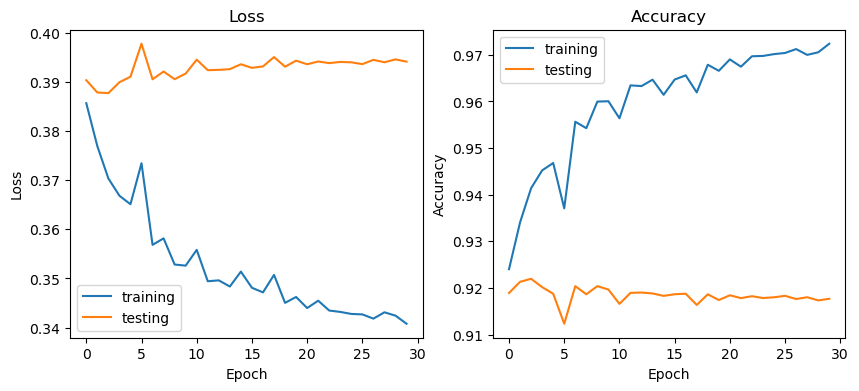

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(hist_train_loss, label = 'training')
ax1.plot(hist_test_loss, label = 'testing')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist_train_acc, label = 'training')
ax2.plot(hist_test_acc, label = 'testing')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

### Guardar modelo

Cuidado de no reescribir

In [23]:
ruta_archivo = '.\modelos\pytorch_conectividad_model1.pth'
#torch.save(model.state_dict(), ruta_archivo)

Cargar el modelo

In [21]:
#model_new = MLP(input_size = 190, hidden = 300, n_classes = 2)
#model_new.load_state_dict(torch.load(ruta_archivo))